Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Num classes:  15
Class weights prepared.
Model: "leafnet_mobilenetv2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 preprocess_input (Lambda)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                     

INFO:tensorflow:Assets written to: ..\models\leafnet_v1\saved_model\assets


INFO:tensorflow:Assets written to: ..\models\leafnet_v1\saved_model\assets


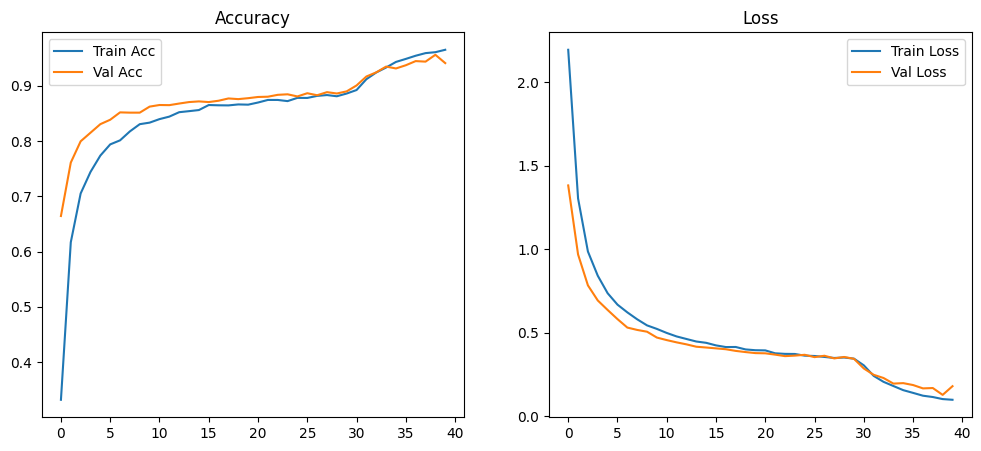

Model and artifacts saved to ..\models\leafnet_v1


In [1]:
# 03_Model_Training.py
# Copy into 03_Model_Training.ipynb cells or run as script inside notebooks.

import os
import json
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# CONFIG
PROJECT_ROOT = pathlib.Path("..")
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "PlantVillage"
MODELS_DIR = PROJECT_ROOT / "models" / "leafnet_v1"
os.makedirs(MODELS_DIR, exist_ok=True)

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42
EPOCHS = 30  # train with early stopping

# Load datasets (same as in preprocessing)
train_ds = tf.keras.utils.image_dataset_from_directory(
    str(DATA_DIR),
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    str(DATA_DIR),
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Num classes: ", num_classes)

# Save class names copy (in case not saved earlier)
with open(PROJECT_ROOT / "models" / "class_names.json", "w", encoding="utf-8") as f:
    json.dump(class_names, f, indent=2)

# Prepare datasets for performance (no normalization here)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Compute class weights from train labels to mitigate class imbalance
y_labels = []
for _, y in train_ds.unbatch().map(lambda x, y: (x, y)).as_numpy_iterator():
    # above returns (image, label) tuples; we only need labels => but unbatch returns (img, label) pairs
    pass
# Simpler robust approach: extract labels by iterating over train_ds batches
labels_list = []
for images_batch, labels_batch in train_ds.unbatch().batch(1024):  # batch to reduce iteration overhead
    labels_list.append(labels_batch.numpy())
if labels_list:
    y_all = np.concatenate(labels_list, axis=0)
else:
    y_all = np.array([], dtype=np.int32)

from sklearn.utils import class_weight
if y_all.size > 0:
    cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=y_all)
    class_weights = {i: float(w) for i, w in enumerate(cw)}
else:
    class_weights = None

print("Class weights prepared.")


# Build model: augmentation -> preprocess_input -> base -> head
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.08),
    ],
    name="data_augmentation"
)

preprocess_layer = layers.Lambda(preprocess_input, name="preprocess_input")

base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_layer(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs, name="leafnet_mobilenetv2")
model.summary()

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top_5")]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-7),
    ModelCheckpoint(filepath=str(MODELS_DIR / "best_model.h5"), monitor="val_accuracy", save_best_only=True, verbose=1)
]

# Fit
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

# Fine-tune: unfreeze some base layers and train with a smaller LR (optional)
base_model.trainable = True
# Freeze first N layers if you like. Here we fine-tune last 40 layers:
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top_5")]
)

ft_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights
)

# Save final model (SavedModel format) and also an H5 copy for compatibility
model.save(str(MODELS_DIR / "saved_model"), save_format="tf")
model.save(str(MODELS_DIR / "best_model.h5"))

# Save training history plots
import matplotlib.pyplot as plt
acc = history.history.get("accuracy", []) + ft_history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", []) + ft_history.history.get("val_accuracy", [])
loss = history.history.get("loss", []) + ft_history.history.get("loss", [])
val_loss = history.history.get("val_loss", []) + ft_history.history.get("val_loss", [])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.savefig(str(MODELS_DIR / "training_curves.png"))
plt.show()

print("Model and artifacts saved to", MODELS_DIR)
